In [1]:
import requests
from requests import post
import base64
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
from dotenv import load_dotenv
import os
import json

In [17]:
#Spotify API Token

client_id="xxxx"
client_secret="xxxx"
def get_token():
    auth_string = client_id + ":" + client_secret
    auth_bytes = auth_string.encode("utf-8")
    auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")
    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": "Basic " + auth_base64,
        "Content-Type": "application/x-www-form-urlencoded"
    }
    data = {"grant_type": "client_credentials"}
    response = requests.post(url, headers=headers, data=data) 
    json_result = response.json()
    token = json_result["access_token"]
    return token


token = get_token()



In [3]:
##BENİM PLAYLİSTİMDEKİ ŞARKILARIN Çekilmesi

def select_most_frequent_genre(genres_list):
    if genres_list:
        genre_counts = all_genres.loc[genres_list]
        return genre_counts.idxmax()
    else:
        return None

def get_playlist_tracks(token, playlist_id):
    tracks = []
    url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"
    headers = {"Authorization": f"Bearer {token}"}

    while url:
        response = requests.get(url, headers=headers)
        json_response = response.json()
        tracks.extend(json_response['items'])
        url = json_response.get('next')  
    return tracks

def get_audio_features(token, track_ids):
    audio_features = []
    headers = {"Authorization": f"Bearer {token}"}
    for i in range(0, len(track_ids), 100):
        batch_ids = track_ids[i:i+100]
        url = "https://api.spotify.com/v1/audio-features"
        params = {"ids": ','.join(batch_ids)}
        response = requests.get(url, headers=headers, params=params)
        batch_features = response.json()['audio_features']
        audio_features.extend([feature for feature in batch_features if feature])  
    return audio_features

def get_artist_details(token, artist_ids):
    artist_details = []
    headers = {"Authorization": f"Bearer {token}"}
    for i in range(0, len(artist_ids), 50): 
        batch_ids = artist_ids[i:i+50]
        url = "https://api.spotify.com/v1/artists"
        params = {"ids": ','.join(batch_ids)}
        response = requests.get(url, headers=headers, params=params)
        artist_details.extend(response.json()['artists'])
    return artist_details


token = 'xxxxx' 
playlist_id = "3Nfao8ji5fczxcYiw2WS24"

# Playlistteki şarkıların bilgilerinin alınması
tracks = get_playlist_tracks(token, playlist_id)
track_ids = [track['track']['id'] for track in tracks if track.get('track')] 

# Ses özelliklerinin toplanması
audio_features = get_audio_features(token, track_ids)

# Artist ID'lerinin alınması
artist_ids = [track['track']['artists'][0]['id'] for track in tracks if track.get('track') and track['track'].get('artists')]


artist_details = get_artist_details(token, artist_ids)


artist_details = [artist for artist in artist_details if artist is not None]  

# DataFrame Oluşturulması
tracks_df = pd.DataFrame([track['track'] for track in tracks if track.get('track')])
audio_features_df = pd.DataFrame(audio_features)
artist_df = pd.DataFrame(artist_details)


final_df = pd.merge(tracks_df, audio_features_df, left_on='id', right_on='id')


df_exploded = final_df.explode('artists')
df_exploded.reset_index(drop=True, inplace=True)


df_exploded['artist_id'] = df_exploded['artists'].apply(lambda x: x['id'])


df_merged = pd.merge(df_exploded, artist_df[['id', 'genres']], left_on='artist_id', right_on='id')


df_merged = df_merged.drop(columns=['artist_id', 'id_y'])
df_merged = df_merged.rename(columns={'id_x': 'id'})


final_df = df_merged[['name','popularity' ,'id', 'artists', 'genres', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']]
all_genres = final_df['genres'].explode().value_counts()
final_df['genres']=final_df['genres'].apply(select_most_frequent_genre)
print(final_df)


                                          name  popularity  \
0           Savage (feat. Flux Pavilion & MAX)          56   
1                                     Set Free          41   
2                                     Set Free          41   
3                                     The City          40   
4                                     The City          40   
...                                        ...         ...   
3266                                      BGKA          48   
3267                            Figure You Out          74   
3268                            Out Of My Mind          66   
3269   Dance For Me (1, 2, 3) - Stutter Techno          74   
3270  Be My Lover (feat. La Bouche) - 2023 Mix          79   

                          id  \
0     0kD586ste6xyDRqUYhVlCh   
1     6NijhaDhaxRXhzjwP3cQiG   
2     6NijhaDhaxRXhzjwP3cQiG   
3     3Rpl6yBjkVFgaYmw9HKqMu   
4     3Rpl6yBjkVFgaYmw9HKqMu   
...                      ...   
3266  06CHtQ3Skig8F9TmKFruIB   

C:\Users\PC\AppData\Local\Temp\ipykernel_6328\4079942412.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['genres']=final_df['genres'].apply(select_most_frequent_genre)


In [4]:
##GLOBAL TOP 50'deki ŞARKILARIN Çekilmesi


token = 'xxxxxxxxx' 
playlist_id = "37i9dQZEVXbMDoHDwVN2tF"


tracks = get_playlist_tracks(token, playlist_id)
track_ids = [track['track']['id'] for track in tracks if track.get('track')] 


audio_features = get_audio_features(token, track_ids)


artist_ids = [track['track']['artists'][0]['id'] for track in tracks if track.get('track') and track['track'].get('artists')]


artist_details = get_artist_details(token, artist_ids)


artist_details = [artist for artist in artist_details if artist is not None]  


tracks_df = pd.DataFrame([track['track'] for track in tracks if track.get('track')])
audio_features_df = pd.DataFrame(audio_features)
artist_df = pd.DataFrame(artist_details)


df_global = pd.merge(tracks_df, audio_features_df, left_on='id', right_on='id')


df_exploded = df_global.explode('artists')
df_exploded.reset_index(drop=True, inplace=True)


df_exploded['artist_id'] = df_exploded['artists'].apply(lambda x: x['id'])


df_merged = pd.merge(df_exploded, artist_df[['id', 'genres']], left_on='artist_id', right_on='id')


df_merged = df_merged.drop(columns=['artist_id', 'id_y'])
df_merged = df_merged.rename(columns={'id_x': 'id'})


df_global = df_merged[['name','popularity' ,'id', 'artists', 'genres', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']]

all_genres = df_global['genres'].explode().value_counts()
all_genres

def select_most_frequent_genre(genres_list):
    if genres_list:
        genre_counts = all_genres.loc[genres_list]
        return genre_counts.idxmax()
    else:
        return None

df_global['genres'] = df_global['genres'].apply(select_most_frequent_genre)
df_global

C:\Users\PC\AppData\Local\Temp\ipykernel_6328\3504203671.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_global['genres'] = df_global['genres'].apply(select_most_frequent_genre)


,name,popularity,id,artists,genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,MILLION DOLLAR BABY,94,7fzHQizxTqy8wTXwlrgPQQ,{'external_urls': {'spotify': 'https://open.sp...,chill abstract hip hop,0.849,0.699,1,-5.106,0,0.0436,0.09820,0.000215,0.0680,0.9270,138.003,4
1,Not Like Us,94,6AI3ezQ4o3HUoP6Dhudph3,{'external_urls': {'spotify': 'https://open.sp...,rap,0.898,0.472,1,-7.001,1,0.0776,0.01070,0.000000,0.1410,0.2140,101.061,4
2,Not Like Us,94,6AI3ezQ4o3HUoP6Dhudph3,{'external_urls': {'spotify': 'https://open.sp...,rap,0.898,0.472,1,-7.001,1,0.0776,0.01070,0.000000,0.1410,0.2140,101.061,4
3,Not Like Us,94,6AI3ezQ4o3HUoP6Dhudph3,{'external_urls': {'spotify': 'https://open.sp...,rap,0.898,0.472,1,-7.001,1,0.0776,0.01070,0.000000,0.1410,0.2140,101.061,4
4,euphoria,93,77DRzu7ERs0TX3roZcre7Q,{'external_urls': {'spotify': 'https://open.sp...,rap,0.831,0.643,1,-5.002,1,0.1100,0.04600,0.000000,0.0840,0.1420,139.948,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,"Good Luck, Babe!",90,0WbMK4wrZ1wFSty9F7FCgu,{'external_urls': {'spotify': 'https://open.sp...,indie pop,0.700,0.582,11,-5.960,0,0.0356,0.05020,0.000000,0.0881,0.7850,116.712,4
130,Rim Tim Tagi Dim,74,5TswDbxMnxptgFTf6ZxvXQ,{'external_urls': {'spotify': 'https://open.sp...,None,0.587,0.872,9,-6.700,1,0.0342,0.00218,0.000937,0.4740,0.5770,128.037,4
131,The Night We Met,90,3hRV0jL3vUpRrcy398teAU,{'external_urls': {'spotify': 'https://open.sp...,indie folk,0.448,0.369,9,-9.514,1,0.0452,0.96800,0.272000,0.6380,0.0998,174.097,3
132,Come back to me,74,2RNut2tMgGnggdKCxzLLNM,{'external_urls': {'spotify': 'https://open.sp...,k-rap,0.623,0.462,4,-7.820,0,0.0326,0.39700,0.011500,0.0492,0.3440,73.007,4


In [5]:
print("\nTemel İstatistikler:\n")
print(final_df.describe())
print(df_global.info())


Temel İstatistikler:

        popularity  danceability       energy          key     loudness  \
count  3271.000000   3271.000000  3271.000000  3271.000000  3271.000000   
mean     40.130235      0.679705     0.641732     5.464078    -7.749341   
std      26.413360      0.127519     0.157075     3.541175     3.035662   
min       0.000000      0.099300     0.028700     0.000000   -28.476000   
25%      14.000000      0.607000     0.551000     2.000000    -9.316000   
50%      48.000000      0.702000     0.655000     5.000000    -7.148000   
75%      61.000000      0.760000     0.768000     9.000000    -5.658000   
max      88.000000      0.982000     0.976000    11.000000    -1.299000   

              mode  speechiness  acousticness  instrumentalness     liveness  \
count  3271.000000  3271.000000   3271.000000       3271.000000  3271.000000   
mean      0.435035     0.148773      0.265473          0.008742     0.173126   
std       0.495837     0.117156      0.219018          0.0569

C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


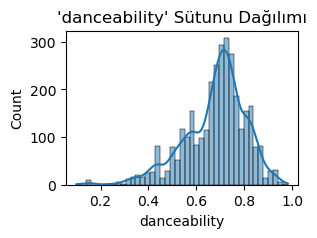

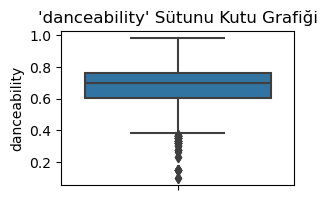

C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


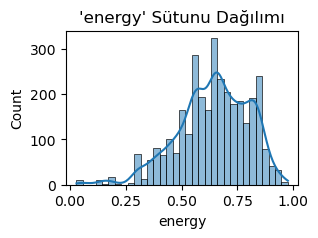

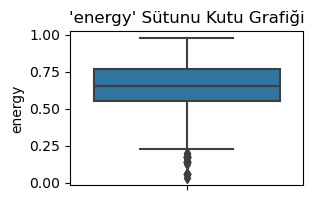

C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


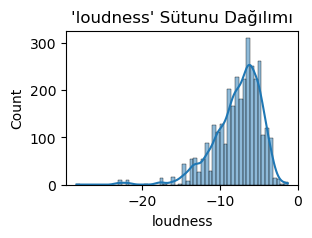

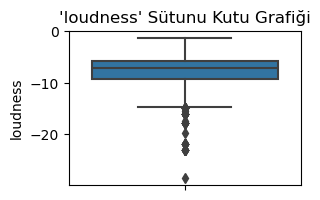

C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


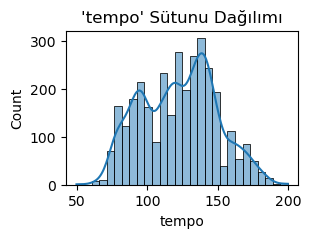

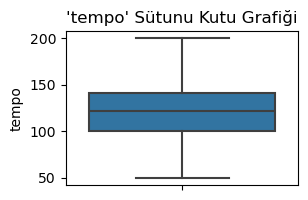

C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


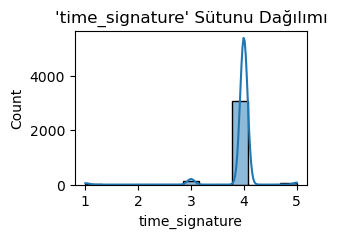

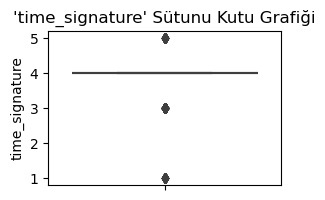

C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


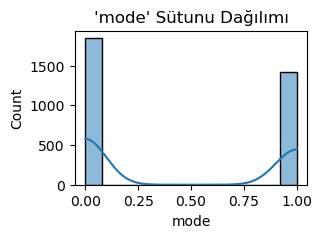

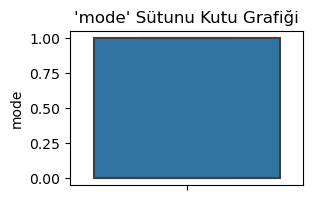

C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


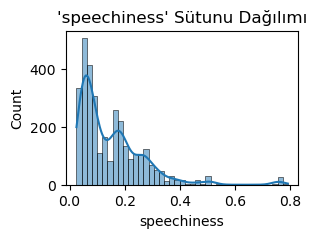

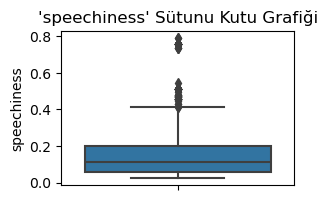

C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


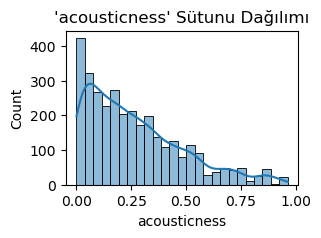

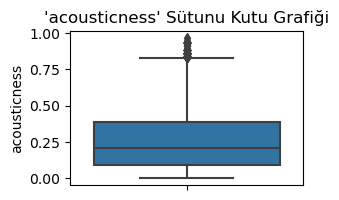

C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):

KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x000002095690A5C0> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



Error in callback <function flush_figures at 0x000002096E9BEFC0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [6]:
for col in ['danceability', 'energy', 'loudness', 'tempo','time_signature','mode','speechiness','acousticness','instrumentalness','liveness','valence'  ]:
    # Histogram
    plt.figure(figsize=(3, 2))
    sns.histplot(final_df[col], kde=True)
    plt.title(f"'{col}' Sütunu Dağılımı")
    plt.show()

   
    plt.figure(figsize=(3, 2))
    sns.boxplot(y=final_df[col])
    plt.title(f"'{col}' Sütunu Kutu Grafiği")
    plt.show()

C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


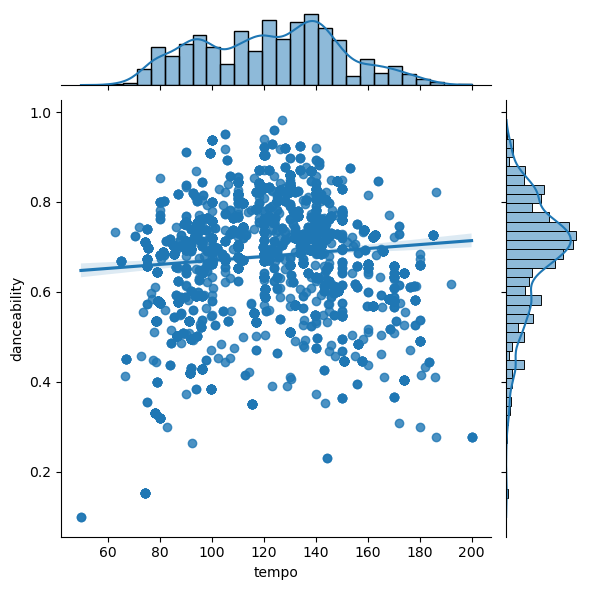

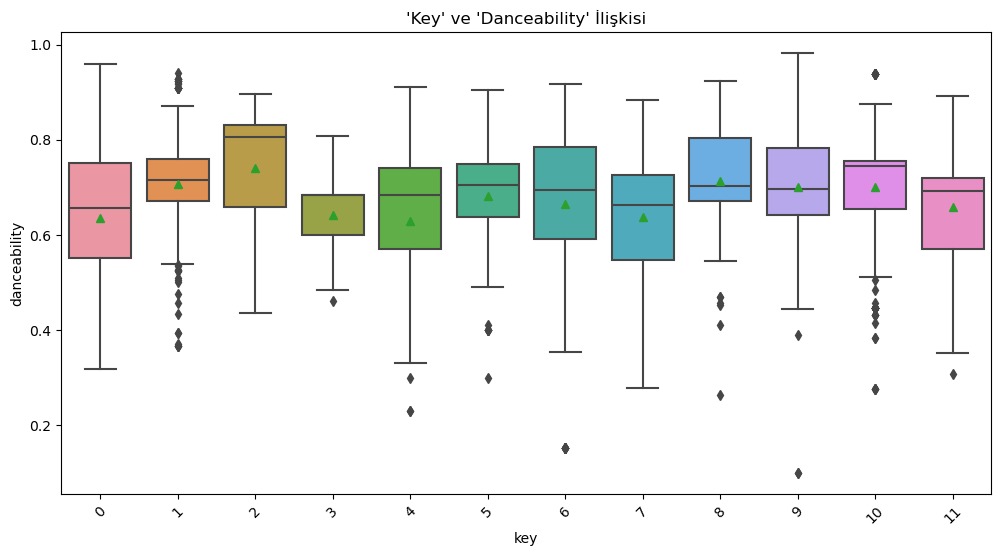

In [7]:


sns.jointplot(x='tempo', y='danceability', data=final_df, kind='reg') 
plt.show()


plt.figure(figsize=(12, 6))
sns.boxplot(x='key', y='danceability', data=final_df, showmeans=True)
plt.xticks(rotation=45)
plt.title("'Key' ve 'Danceability' İlişkisi")
plt.show()


In [8]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
final_df = final_df.dropna(subset=['genres'])
df_global = df_global.dropna(subset=['genres'])
final_df = final_df.drop(columns=['artists']).drop_duplicates()
df_global = df_global.drop(columns=['artists']).drop_duplicates()


all_genres = pd.concat([final_df['genres'], df_global['genres']]).unique()


le.fit(all_genres)


final_df['encoded_genre'] = le.transform(final_df['genres'])
df_global['encoded_genre'] = le.transform(df_global['genres'])



In [11]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

final_df['dance_energy']=final_df['danceability']  * final_df['energy']
df_global['dance_energy']=df_global['danceability'] * df_global['energy']


scaler = MinMaxScaler()
scaled_features_final = scaler.fit_transform(final_df[['encoded_genre','danceability', 'energy', 'loudness', 'tempo','time_signature','mode','speechiness','acousticness','instrumentalness','liveness','valence']])
scaled_features_global = scaler.transform(df_global[['encoded_genre','danceability', 'energy', 'loudness', 'tempo','time_signature','mode','speechiness','acousticness','instrumentalness','liveness','valence']])
pca = PCA(n_components=0.95)  # Keep 95% of variance
pca.fit(scaled_features_final) 

reduced_features_final = pca.transform(scaled_features_final)
reduced_features_global = pca.transform(scaled_features_global)
similarity_matrix=cosine_similarity(reduced_features_final,reduced_features_global)


recommendations = []
for i in range(len(final_df)):
    similar_song_indices=similarity_matrix[i].argsort()[-5:][::-1]
    for j in similar_song_indices:
        recommendations.append({"my_playlist_song":final_df['name'].iloc[i],
                               "global_top50_song":df_global['name'].iloc[j],
                                "genre_my_playlist":final_df['genres'].iloc[i],
                                "genre_global":df_global['genres'].iloc[j],
                               "similarity_score":similarity_matrix[i][j]})



recommendations_df = pd.DataFrame(recommendations)
recommendations_df=recommendations_df[recommendations_df['genre_my_playlist']== recommendations_df['genre_global']]
top_50_similar_songs = recommendations_df.sort_values(by='similarity_score', ascending=False).head(5)


print(top_50_similar_songs[['my_playlist_song', 'global_top50_song','similarity_score']].to_markdown(index=False, numalign="left", stralign="left"))



| my_playlist_song                           | global_top50_song               | similarity_score   |
|:-------------------------------------------|:--------------------------------|:-------------------|
| Happier                                    | Espresso                        | 0.985324           |
| Formula                                    | I Can Do It With a Broken Heart | 0.962067           |
| Roses (with Juice WRLD feat. Brendon Urie) | Cruel Summer                    | 0.958517           |
| Everyday                                   | Sweater Weather                 | 0.958416           |
| Come & Go (with Marshmello)                | Sweater Weather                 | 0.948486           |


In [14]:
scaled_features_finals=pd.DataFrame(scaled_features_final,columns=[['encoded_genre','danceability', 'energy', 'loudness', 'tempo','time_signature','mode','speechiness','acousticness','instrumentalness','liveness','valence']])
scaled_features_global=pd.DataFrame(scaled_features_global,columns=[['encoded_genre','danceability', 'energy', 'loudness', 'tempo','time_signature','mode','speechiness','acousticness','instrumentalness','liveness','valence']])
variance_final=scaled_features_final.var()
variance_global=scaled_features_global.var()
print(variance_final)
print("---")
print(variance_global)

0.10965565856587027
---
encoded_genre       0.023077
danceability        0.027743
energy              0.032273
loudness            0.008938
tempo               0.046985
time_signature      0.017277
mode                0.213002
speechiness         0.009125
acousticness        0.078388
instrumentalness    0.002735
liveness            0.016109
valence             0.071106
dtype: float64
